In [3]:
# 크롤러를 만들기 전 필요한 도구들을 임포트합니다.
import requests
import pandas as pd
from bs4 import BeautifulSoup

# 페이지 수, 카테고리, 날짜를 입력값으로 받습니다.
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성합니다. 파서는 html.parser를 사용합니다.
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'만을 가져옵니다.
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [4]:
url_list = make_urllist(2, 105, 20240107)
print('뉴스 기사의 개수: ',len(url_list))

뉴스 기사의 개수:  40


In [5]:
idx2word = {'100' : '정치', '101' : '경제', '102' : '사회', '103' : '생활/문화', '104' : '세계','105' : 'IT/과학'}

In [120]:
from newspaper import Article

#- 데이터프레임을 생성하는 함수입니다.
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    try:
        article.download()
    except ArticleException:
        continue
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류로 붙여줍니다.
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명을 붙여줍니다.
  df['code'] = idx2word[str(code)]
  return df

In [7]:
data = make_data(url_list, 105)
#- 상위 10개만 출력해봅니다.
data[:10]

,news,code
0,‘스나이퍼’ 장성호 “계단 오르기로 짧고 굵게 땀 흘려요”[이헌재의 인생홈런],IT/과학
1,거침없는 인도의 우주탐사 저력…태양관측용 위성 목표지점 `안착`,IT/과학
2,"""CES 2024 참가 한국 기업 772개…세계 3위 수준""",IT/과학
3,"SK텔레콤, AI 기업 도약 위해 전담조직 만들고 자문단 구성",IT/과학
4,욱일기에 성범죄자 방송까지...네이버 '치지직' 시범서비스부터 논란,IT/과학
5,"SK하이닉스, 세계 최대 전자전시회 CES 2024 참가",IT/과학
6,"""얼굴·키·직업·학교까지 고를 수 있다""…뜨는 '신종 소개팅'",IT/과학
7,"‘실적 대미지’ 게임업계, 구조조정 한파",IT/과학
8,중국·인도·일본 없으면 큰일난다…원료의약품 자급도 15년 만에 최저치,IT/과학
9,"알쏭달쏭 아이 말, 부모 귀엔 잘 들린다[신경과학 저널클럽]",IT/과학


In [8]:
code_list = [100, 101, 105]

code_list

[100, 101, 105]

In [9]:
# 이 코드 리스트, 날짜, 페이지 수 입력받는 함수
def make_total_data(page_num, code_list, date):
  df = None

  for code in code_list:
    url_list = make_urllist(page_num, code, date)
    df_temp = make_data(url_list, code)
    print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

    if df is not None:
      df = pd.concat([df, df_temp])
    else:
      df = df_temp

  return df

In [10]:
df = make_total_data(40, code_list, 20240101)

100번 코드에 대한 데이터를 만들었습니다.
101번 코드에 대한 데이터를 만들었습니다.
105번 코드에 대한 데이터를 만들었습니다.


In [11]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
# 저장경로는 이번 프로젝트를 위해 만든 폴더로 지정해 주세요.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data(x40).csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data(x40).csv File Saved!


In [12]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data(x40).csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,"尹, 신년사 통해 “민생 회복의 한 해” 굳은 약속…부동산 등 부각",정치
1,“군 간부 1인 1실”…달라지는 국방 정책은?,정치
2,총선 승부처는? 쇄신 공천·수도권 싸움 ‘승패’,정치
3,강원 정당 새해 인사…‘총선 승리’ 다짐,정치
4,'김건희 특검' 아닌 '도이치 특검' 표현한 한동훈 속내는?,정치


In [13]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
df['news']

0             신년사 통해 민생 회복의 한 해 굳은 약속부동산 등 부각
1                         군 간부 인 실달라지는 국방 정책은
2                      총선 승부처는 쇄신 공천수도권 싸움 승패
3                         강원 정당 새해 인사총선 승리 다짐
4                김건희 특검 아닌 도이치 특검 표현한 한동훈 속내는
                        ...                  
2203            윤승규 가톨릭대 서울성모병원장 갑진년 목표는 융합성장
2204           오유경 식약처장 새해 규제혁신국민소통마약감시 추진 계속
2205                  조규홍 복지부 장관 년 국민연금 개혁할 것
2206    이화성 가톨릭중앙의료원장 새해 융합 혁신 기반 미래 경쟁력 창출하자
2207                   엔씨 올해 내실 다졌다새해는 결실의 시간
Name: news, Length: 2208, dtype: object

In [37]:
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

news    0
code    0
dtype: int64
news    0
code    0
dtype: int64


In [38]:
# 중복된 샘플들을 제거합니다.
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  1761


<AxesSubplot:>

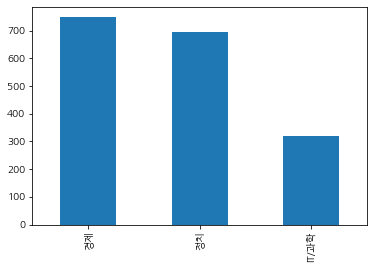

In [39]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [40]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    319
1     경제    748
2     정치    694


In [20]:
!pip install PyKomoran

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 14.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 KB 23.3 MB/s eta 0:00:00
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9
    Uninstalling py4j-0.10.9:
      Successfully uninstalled py4j-0.10.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyspark 3.1.2 requires py4j==0.10.9, but you have py4j 0.10.9.2 which is incompatible.


In [22]:
from PyKomoran import *

In [26]:
from konlpy.tag import Komoran

In [27]:
from PyKomoran import *
komoran = Komoran("EXP")
print(komoran.get_plain_text("KOMORAN은 한국어 형태소 분석기입니다."))

KOMORAN/SL 은/JX 한국어/NNP 형태소/NNP 분석기/NNG 이/VCP ㅂ니다/EF ./SF


In [30]:
from konlpy.tag import Kkma
kkma = Kkma()
print(kkma.morphs(u'공부를 하면할수록 모르는게 많다는 것을 알게 됩니다.'))
print(kkma.nouns(u'대학에서 DB, 통계학, 이산수학 등을 배웠지만...'))
print(kkma.pos(u'다 까먹어버렸네요?ㅋㅋ'))
print(kkma.sentences(u'그래도 계속 공부합니다. 재밌으니까!'))

['공부', '를', '하', '면', '하', 'ㄹ수록', '모르', '는', '것', '이', '많', '다는', '것', '을', '알', '게', '되', 'ㅂ니다', '.']
['대학', '통계학', '이산', '이산수학', '수학', '등']
[('다', 'MAG'), ('까먹', 'VV'), ('어', 'ECD'), ('버리', 'VXV'), ('었', 'EPT'), ('네요', 'EFN'), ('?', 'SF'), ('ㅋㅋ', 'EMO')]
['그래도 계속 공부합니다.', '재밌으니까!']


In [163]:
from konlpy.tag import Mecab

tokenizer = Mecab()
kor_text = '밤에 귀가하던 여성에게 범죄를 시도한 대 남성이 구속됐다서울 제주경찰서는 \
            상해 혐의로 씨를 구속해 수사하고 있다고 일 밝혔다씨는 지난달 일 피해 여성을 \
            인근 지하철 역에서부터 따라가 폭행을 시도하려다가 도망간 혐의를 받는다피해 \
            여성이 저항하자 놀란 씨는 도망갔으며 신고를 받고 주변을 수색하던 경찰에 \
            체포됐다피해 여성은 이 과정에서 경미한 부상을 입은 것으로 전해졌다'

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['밤', '에', '귀가', '하', '던', '여성', '에게', '범죄', '를', '시도', '한', '대', '남성', '이', '구속', '됐', '다', '서울', '제주', '경찰서', '는', '상해', '혐의', '로', '씨', '를', '구속', '해', '수사', '하', '고', '있', '다고', '일', '밝혔', '다', '씨', '는', '지난달', '일', '피해', '여성', '을', '인근', '지하철', '역', '에서부터', '따라가', '폭행', '을', '시도', '하', '려다가', '도망간', '혐의', '를', '받', '는다', '피해', '여성', '이', '저항', '하', '자', '놀란', '씨', '는', '도망갔으며', '신고', '를', '받', '고', '주변', '을', '수색', '하', '던', '경찰', '에', '체포', '됐', '다', '피해', '여성', '은', '이', '과정', '에서', '경미', '한', '부상', '을', '입', '은', '것', '으로', '전해졌', '다']


In [64]:
stopwords = ["에", "하", "더", "ㄴ", "에게", "를", "하", "ㄴ", "대", "이", "되", "었", "다", "는", "로", "씨", "를", "하", "어", "하", "고", "있", "다고", "일", "었", "다", "씨", "는", "지난달", "일", "을", "역", "에서", "부터", "하", "려", "아", "ㄴ", "를", "받", "는", "다", "이", "하", "자", "ㄴ", "씨", "는", "었", "으며", "를", "받", "고", "을", "하", "더", "ㄴ", "에", "되", "었", "다", "은", "이", "과정", "에서", "하", "ㄴ", "을", "입", "은", "것", "으로", "전하", "어", "지", "었", "다"]

In [79]:
def preprocessing(data):
    text_data = []

    for sentence in data:
        try:
            temp_data = []
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(temp_data)
        except Exception as e:
            print(f"전처리 중 오류 발생: {e}")
            print(f"오류가 발생한 문장: {sentence}")

    text_data = list(map(' '.join, text_data))

    return text_data


In [77]:
def preprocessing(data):
    text_data = []

    for i, sentence in enumerate(data):
        try:
            temp_data = []
            #- 토큰화
            tokenized_sentence = tokenizer.morphs(sentence)
            print(f"{i + 1}번째 문장: {tokenized_sentence}")
            #- 불용어 제거
            temp_data = [word for word in tokenized_sentence if word not in stopwords]
            text_data.append(temp_data)
        except Exception as e:
            print(f"전처리 중 오류 발생: {e}")
            print(f"오류가 발생한 문장: {sentence}")
            print(f"이전 문장: {data[i-1] if i > 0 else '없음'}")

    text_data = list(map(' '.join, text_data))

    return text_data


In [75]:
df['news'][0]

' 신년사 통해 민생 회복의 한 해 굳은 약속부동산 등 부각'

In [71]:
print(df[df['news'].isnull() | (df['news'] == '')])

Empty DataFrame
Columns: [news, code]
Index: []


In [78]:
text_data = preprocessing(df['news'])
print(text_data[0])

1번째 문장: ['신년사', '통해', '민생', '회복', '의', '한', '해', '굳', '은', '약속', '부동산', '등', '부각']
2번째 문장: ['군', '간부', '이', 'ㄴ', '실', '달라지', '는', '국방', '정책', '은']
3번째 문장: ['총선', '승부처', '는', '쇄신', '공천', '수도권', '싸움', '승패']
4번째 문장: ['강원', '정당', '새해', '인사', '총선', '승리', '다짐']
5번째 문장: ['김', '건희', '특검', '아니', 'ㄴ', '도이치', '특검', '표현', '하', 'ㄴ', '한동', '훈', '속내', '는']
6번째 문장: ['출연', '대', '총선', '여야', '총선', '행보', '본격화']
7번째 문장: ['이', '낙', '연', '국민', '께', '양자택일', '아니', 'ㄴ', '새', '롭', 'ㄴ', '선택지', '드리', '어야']
8번째 문장: ['여야', '총선', '앞', '으로', '의회', '권력', '탈환', '수성', '사활']
9번째 문장: ['김', '현기', '서울시', '의회', '의장', '년', '제야', '의', '종', '타종']
10번째 문장: ['윤', '대통령', '행동', '하', '는', '정부', '되', 'ㄹ', '것', '국민', '민생', '강조']
11번째 문장: ['총선', '여야', '지지율', '초', '접전', '하', 'ㄴ', '동', '훈', '이재명', '대권', '경쟁', '도', '치열']
12번째 문장: ['김', '정', '은', '딸', '주', '애', '와', '신년', '경축', '공연', '관람', '당', '간부', '연회']
13번째 문장: ['총선', '일', '앞', '으로', '총선', '주요', '일정', '은']
14번째 문장: ['이', '준석', '신당', '월', '중순', '창당', '모든', '것', '바로', '잡', '을', '방법', '정치'

KeyError: 1054

In [80]:
text_data = preprocessing(df['news'])
print(text_data[0])

전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:          
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:              
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:       
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:        
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:   
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:    
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:            
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:             
신년사 통해 민생 회복 의 한 해 굳 약속 부동산 등 부각


In [54]:
print(text_data[0])

신년사 통해 민생 회복 해 굳 약속 부동산 부각


In [81]:
print(len(text_data))

1753


In [82]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [83]:
X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

In [84]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 1320
테스트용 뉴스 기사의 개수 :  441
훈련용 레이블의 개수 :  1320
테스트용 레이블의 개수 :  441


In [85]:
#- 단어의 수를 카운트하는 사이킷런의 카운트벡터라이저입니다.
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

#- 카운트벡터라이저의 결과로부터 TF-IDF 결과를 얻습니다.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

#- 나이브 베이즈 분류기를 수행합니다.
#- X_train은 TF-IDF 벡터, y_train은 레이블입니다.
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [86]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [95]:
new_sent = preprocessing(["민주당 일각에서 법사위의 체계·자구 심사 기능을 없애야 한다는 \
                           주장이 나오는 데 대해 “체계·자구 심사가 법안 지연의 수단으로 \
                          쓰이는 것은 바람직하지 않다”면서도 “국회를 통과하는 법안 중 위헌\
                          법률이 1년에 10건 넘게 나온다. 그런데 체계·자구 심사까지 없애면 매우 위험하다”고 반박했다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['정치']


In [93]:
new_sent = preprocessing(["반세기 만의 미국 달 착륙선은 결국 달 근처에도 가보지 못한 채 실패로 끝났다.\
                           미국의 우주기업 애스트로보틱은 9일(현지시각) “불행하게도 연료가 누출되는 상황임을 고려할 때\
                          페레그린 우주선이 달에 연착륙할 가능성은 없다”고 밝혔다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['경제']


In [94]:
new_sent = preprocessing(["20분기 연속으로 적자에 시달리는 LG전자가 브랜드 이름부터 성능, 디자인까지 대대적인 변화를 \
                          적용한 LG 벨벳은 등장 전부터 온라인 커뮤니티를 뜨겁게 달궜다. 사용자들은 “디자인이 예쁘다”, \
                          “슬림하다”는 반응을 보이며 LG 벨벳에 대한 기대감을 드러냈다."])
print(clf.predict(tfidf_vectorizer(new_sent)))

['경제']


In [97]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.64      0.13      0.21        70
          경제       0.71      0.90      0.79       186
          정치       0.85      0.87      0.86       185

    accuracy                           0.77       441
   macro avg       0.73      0.63      0.62       441
weighted avg       0.76      0.77      0.73       441



### 새로운 날짜데이터 추가 함수

In [121]:
import pandas as pd

# 기존의 make_total_data 함수
def make_total_data(page_num, code_list, date):
    df = None

    for code in code_list:
        url_list = make_urllist(page_num, code, date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 만들었습니다.')

        if df is not None:
            df = pd.concat([df, df_temp])
        else:
            df = df_temp

    return df

# 새로운 날짜의 데이터 추가 함수
def add_new_date_data(page_num, code_list, new_date):
    # 기존 데이터프레임 불러오기
    existing_df = pd.read_csv('news_data_updated.csv')  # 현재 파일명

    # 새로운 날짜의 데이터 수집 및 추가
    for code in code_list:
        url_list = make_urllist(page_num, code, new_date)
        df_temp = make_data(url_list, code)
        print(str(code)+'번 코드에 대한 데이터를 추가했습니다.')

        existing_df = pd.concat([existing_df, df_temp])

    # 새로운 데이터를 추가한 데이터프레임을 저장
    existing_df.to_csv('news_data_updated_2.csv', index=False)  # 현재 파일명

In [100]:
# 새로운 날짜의 데이터 추가 함수 호출
code_list = [100, 105]

add_new_date_data(30, code_list, 20240102)

100번 코드에 대한 데이터를 추가했습니다.
105번 코드에 대한 데이터를 추가했습니다.


In [101]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  1761


,news,code
0,"尹, 신년사 통해 “민생 회복의 한 해” 굳은 약속…부동산 등 부각",정치
1,“군 간부 1인 1실”…달라지는 국방 정책은?,정치
2,총선 승부처는? 쇄신 공천·수도권 싸움 ‘승패’,정치
3,강원 정당 새해 인사…‘총선 승리’ 다짐,정치
4,'김건희 특검' 아닌 '도이치 특검' 표현한 한동훈 속내는?,정치


In [103]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
df['news']

0              신년사 통해 민생 회복의 한 해 굳은 약속부동산 등 부각
1                          군 간부 인 실달라지는 국방 정책은
2                       총선 승부처는 쇄신 공천수도권 싸움 승패
3                          강원 정당 새해 인사총선 승리 다짐
4                 김건희 특검 아닌 도이치 특검 표현한 한동훈 속내는
                         ...                  
3403    신년사 박진효 브로드밴드 사장 모든 영역에서 의 일상화로 진일보할 것
3404               일본 강진 원인 지하수활단층지질학적 특성 등 추정
3405                     서머너즈 워 주년 맞이 년 이벤트 실시
3406       신년사 조규곤 파수 대표 고객  활용 돕는  기업으로 거듭날 것
3407                        클라우드 김동훈 대표 단독 체제로
Name: news, Length: 3408, dtype: object

In [104]:
# 데이터 null 값 있는지 확인
print(df.isnull().sum())
# 있으면 지우기
df = df.dropna()
print(df.isnull().sum())

news    6
code    0
dtype: int64
news    0
code    0
dtype: int64


In [105]:
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  2871


<AxesSubplot:>

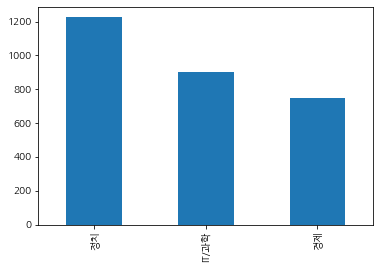

In [106]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')

In [107]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    899
1     경제    748
2     정치   1224


In [108]:
text_data = preprocessing(df['news'])
print(text_data[100])

전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:          
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:              
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:       
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:        
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:   
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:    
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:            
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:             
전처리 중 오류 발생: java.lang.NullPointerException
오류가 발생한 문장:      
윤 대통령 패거리 카르텔 타파 새해 국정 도 다시 이념 앞


In [109]:
print(text_data[0])

신년사 통해 민생 회복 의 한 해 굳 약속 부동산 등 부각


In [111]:
X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

In [112]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2153
테스트용 뉴스 기사의 개수 :  718
훈련용 레이블의 개수 :  2153
테스트용 레이블의 개수 :  718


In [113]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [114]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [117]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.72      0.76      0.74       224
          경제       0.79      0.40      0.53       191
          정치       0.74      0.93      0.82       303

    accuracy                           0.74       718
   macro avg       0.75      0.70      0.70       718
weighted avg       0.74      0.74      0.72       718



In [125]:
# 새로운 날짜 데이터 추가 함수 호출
code_list = [100, 101, 105]

add_new_date_data(20, code_list, 20240112)

100번 코드에 대한 데이터를 추가했습니다.
101번 코드에 대한 데이터를 추가했습니다.
105번 코드에 대한 데이터를 추가했습니다.


In [126]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  2871


In [186]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data_updated_2.csv"
df = pd.read_table(csv_path, sep=',')

In [187]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  4608


In [188]:
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
df['news']

0        신년사 통해 민생 회복의 한 해 굳은 약속부동산 등 부각
1                    군 간부 인 실달라지는 국방 정책은
2                 총선 승부처는 쇄신 공천수도권 싸움 승패
3                    강원 정당 새해 인사총선 승리 다짐
4           김건희 특검 아닌 도이치 특검 표현한 한동훈 속내는
                      ...               
4603        대 고령자도 웨어러블 로봇 입고 가뿐히 북한산 등반
4604       저커버그 직접 키운 소고기 먹방온실가스 어쩌려고 비난
4605            화제 만발 비서 래빗사전 주문에 만대 몰려 
4606              밀리의 서재 오브제북 지니서 무료로 본다
4607     워게이밍 월드오브탱크 영화 스내치 테마 배틀 패스 선보여
Name: news, Length: 4608, dtype: object

In [189]:
print(df.isnull().sum())
# 있으면 지우기
df = df.dropna()
print(df.isnull().sum())

news    6
code    0
dtype: int64
news    0
code    0
dtype: int64


In [190]:
df.drop_duplicates(subset=['news'], inplace=True)
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  2932


    code  count
0  IT/과학    918
1     경제    772
2     정치   1242


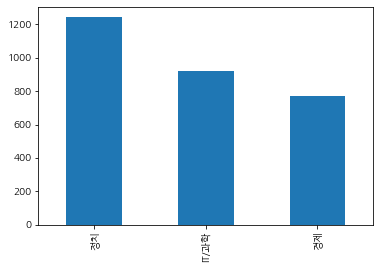

In [191]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "NanumGothic"

df['code'].value_counts().plot(kind = 'bar')
print(df.groupby('code').size().reset_index(name = 'count'))

In [192]:
X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

In [193]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2199
테스트용 뉴스 기사의 개수 :  733
훈련용 레이블의 개수 :  2199
테스트용 레이블의 개수 :  733


In [194]:
# stopwords = ["으로", "은", "는", "ㄴ", "이", "가", "하", "것", "ㅁ", "ㄹ",
#              "어", "등", "도", "었", "겠", "만", "와", "과", "의", "에",
#              "아니", "없", "되", "로", "며", "지", "언급", "위", "때문", "로",
#              "기", "를", "찾", "곳", "어야", "김", "습니다", "다", "ㄴ다", "만들"]

stopwords = ["으로", "은", "는", "던", "이", "가", "하", "것", "수", "한",
             "어", "등", "도", "었", "겠", "만", "와", "과", "의", "에",
             "아니", "없", "되", "로", "며", "지", "언급", "위", "때문", "로",
             "기", "을", "를", "찾", "곳", "어야", "김", "습니다", "다", "낳",
             "만들", "러", "엥", "명", "외", "또", "준비", "제시", "고", "님", "한다"]

In [195]:
def preprocessing(data):
    text_data = []

    for sentence in data:
        try:
            temp_data = []
            #- 토큰화
            temp_data = tokenizer.morphs(sentence)
            #- 불용어 제거
            temp_data = [word for word in temp_data if word not in stopwords]
            text_data.append(temp_data)
        except Exception as e:
            print(f"전처리 중 오류 발생: {e}")
            print(f"오류가 발생한 문장: {sentence}")

    text_data = list(map(' '.join, text_data))

    return text_data

In [196]:
text_data = preprocessing(df['news'])
print(text_data[100])

윤 대통령 패거리 카르텔 타파 새해 국정 다시 이념 앞


In [197]:
X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 2199
테스트용 뉴스 기사의 개수 :  733
훈련용 레이블의 개수 :  2199
테스트용 레이블의 개수 :  733


In [198]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [199]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [200]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.70      0.73      0.71       224
          경제       0.74      0.39      0.51       193
          정치       0.74      0.94      0.83       316

    accuracy                           0.73       733
   macro avg       0.73      0.68      0.68       733
weighted avg       0.73      0.73      0.71       733



In [201]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

svm_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear'))
])

svm_clf.fit(X_train, y_train)

y_pred_svm = svm_clf.predict(X_test)

f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
print('SVM F1 Score:', f1_svm)

SVM F1 Score: 0.7515690042362821


In [202]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

rf_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(n_estimators=100))  # You can experiment with the number of trees
])

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print('Random Forest F1 Score:', f1_rf)

Random Forest F1 Score: 0.7061031102004319


In [203]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(df['news'].values, df['code'].values, random_state=0)

svm_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC(kernel='linear'))
])

parameters = {
    'clf__C': [0.1, 1, 10, 100],  
    'clf__gamma': ['scale', 'auto'],
    'clf__kernel': ['linear', 'rbf', 'poly']
}

grid_search = GridSearchCV(svm_clf, parameters, cv=5, n_jobs=-1, scoring='f1_weighted')

grid_search.fit(X_train, y_train)

best_svm_clf = grid_search.best_estimator_

y_pred_best_svm = best_svm_clf.predict(X_test)

f1_best_svm = f1_score(y_test, y_pred_best_svm, average='weighted')
print('Best SVM F1 Score:', f1_best_svm)

print('Best Parameters:', grid_search.best_params_)

Best SVM F1 Score: 0.7515690042362821
Best Parameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


### 프로젝트 회고


- Step1) 형태소 분석기 변경해 보기
- Step2) 불용어 추가하기
- Step3) 다른 날짜 데이터 추가하기 
- Kkma를 선택했고, 데이터를 처음에 10배로 하니 너무 정확도가 낮아 40배로 만들어놓은 후 진행했다. 
- Kkma로 나온 결과를 보니 Mecab과 달리 ‘ㄴ’ 과 같은 형태소까지 분석되어 불용어를 추가했다. 특정 단어보다는 뉴스 별 공통적으로 빈도수가 많이 나올 것 같은 단어 조사나 어말어미 같은 것 위주로 추가하였다.

- 그리고 데이터를 추가하였다. 한 번에 100배 불러오는 건 못해도 10배씩 더 불러온 뒤에 그걸 기존 데이터에 합치는 작업으로 진행했다. 

회고, 어려운 건 데이터 불러오는 거 그리고 중간에 Kkma를 사용하니 
전처리 중 오류 발생: java.lang.NullPointerException 하여 예외처리를 하는 데 시간이 오래걸렸다. 카테고리에 대한 것도 영향을 끼칠 수 있다고 생각했따. 예를 들어 사회 경제는 분류하기 애매할 수도 있지 않을까? 하는 생각.. 그치만 처음에는 모든 기사를 자꾸 정치기사로 분류해서 정말 난감했다… 그리고 Mecab을 다시 썼다. 

다른 그루들과도 계속해서 얘기해보았는데 공통적으로 어려운 점들이라고 하면 널값, 데이터 로딩, 불용어 추가 등… 데이터를 넣고 뺴고 같이 진행했고 데이터 공유도 함께 해보았다. 다른 모델로도 돌려봤는데 크게 오르진 않아서 다함께 논의해보고 여러 방향을 찾아가는 과정이 즐거웠다. 오늘은 코딩하느라 생각을 많이 했는데 다음에는 다른 방법과 이론에 대해서도 같이 얘기해보고 싶다. 그루들과 


### 추가
그리고 내부에 카테고리를 4개로 하니 정치분야는 90이 넘기도 하였다! 
역시 정치파트가 가장 특징이 강한가보다!

https://github.com/inseonseo/AIFFEL_Quest/blob/main/Quest_0111/News_category4.ipynb